# Final Project STAT 259: Single Cell Sequencing Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import keras
from keras import layers
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import save_model, load_model

ModuleNotFoundError: No module named 'keras'

## Read data

In [86]:
def setup_data(name):
    """
    ...
    """
    file = f"data/{name}-counts.csv"
    counts = pd.read_csv(file)
    counts.rename(columns={'Unnamed: 0':'index'}, inplace=True)
    counts.set_index("index", inplace=True)
    counts = counts.T
    counts.insert(0, 'cell_label', name)
    return counts

In [90]:
organs = [
    "Kidney",
    "Liver",
]

In [96]:
assert len(organs) == 2

## Feature filter

In [91]:
data = pd.DataFrame()
for organ in organs:
    data = data.append(setup_data(organ))
data.shape

(1846, 23434)

In [92]:
# Remove gene counts with zero variance
std = data.std(axis=0, numeric_only=True)
final_features = list(std[std != 0].index)
data = data[final_features + ["cell_label"]]
data.shape

(1846, 18471)

In [93]:
std = std[final_features]

In [94]:
mu = data.groupby(data["cell_label"]).mean().T

In [106]:
score = np.abs((mu[organs[0]] - mu[organs[1]])/std).sort_values(ascending=False)
score.head(20)

index
Sepp1        0.781411
Bhmt         0.750014
Psen2        0.731537
Gnmt         0.722756
Cd302        0.717035
Cdo1         0.709682
Hpd          0.700787
Fgl1         0.699458
Arg1         0.693576
Serpina1b    0.692899
Tat          0.687784
Serpina1a    0.685803
Otc          0.683865
Adh1         0.679625
Fgb          0.674998
Crp          0.672600
Hmgcs2       0.671819
Apoh         0.670908
Fgg          0.670600
Apoc3        0.669172
dtype: float64

Index(['Sepp1', 'Bhmt', 'Psen2', 'Gnmt', 'Cd302', 'Cdo1', 'Hpd', 'Fgl1',
       'Arg1', 'Serpina1b',
       ...
       'F13b', 'Nop10', 'Alkbh5', 'Dhdh', 'Defb1', 'Aldob', 'Tgds', 'Cml1',
       'Mrps24', 'Atf3'],
      dtype='object', name='index', length=1000)

In [108]:
# Choose subset of gene counts
num_genes = 1000
selected_features = list(score.iloc[:num_genes].index)
data = data[selected_features + ["cell_label"]]
data.shape

(1846, 1001)

## Feature preprocessing

In [109]:
data.iloc[:, :-1] = np.log(data.iloc[:,:-1] + 1)

In [110]:
filepath = "processed_data/data.csv"
data.to_csv(filepath, index=True)

# Lower-dimension representation of the cells

In [111]:
data = pd.read_csv(filepath, index_col=0)

In [112]:
data

,Sepp1,Bhmt,Psen2,Gnmt,Cd302,Cdo1,Hpd,Fgl1,Arg1,Serpina1b,...,Nop10,Alkbh5,Dhdh,Defb1,Aldob,Tgds,Cml1,Mrps24,Atf3,cell_label
A14.MAA000545.3_8_M.1.1,5.105945,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.098612,0.000000,4.356709,0.000000,0.000000,0.000000,0.000000,0.000000,Kidney
E1.MAA000545.3_8_M.1.1,5.700444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,4.875197,0.000000,7.108244,0.000000,0.000000,0.000000,0.693147,Kidney
M4.MAA000545.3_8_M.1.1,2.639057,0.000000,0.000000,0.000000,0.000000,4.744932,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,6.082219,0.000000,0.000000,0.000000,0.000000,0.000000,Kidney
O21.MAA000545.3_8_M.1.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.890372,0.000000,0.000000,3.526361,0.000000,0.000000,0.000000,0.000000,3.637586,Kidney
P4.MAA000545.3_8_M.1.1,6.175867,0.000000,0.000000,5.638355,2.639057,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,8.063063,0.000000,0.000000,3.828641,0.000000,Kidney
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C7.MAA100042.3_9_M.1.1,8.939712,7.624131,6.390241,8.744488,6.111467,6.177944,6.447306,4.836282,7.880426,9.179572,...,6.016157,3.135494,0.000000,0.000000,9.200795,4.110874,7.949797,5.572154,5.648974,Liver
A9.MAA100042.3_9_M.1.1,8.275631,7.848153,5.159055,8.014997,5.968708,4.454347,7.652071,3.496508,7.091742,8.744488,...,4.905275,3.332205,5.433722,0.000000,7.918629,0.693147,4.406719,5.978886,0.000000,Liver
C9.MAA100042.3_9_M.1.1,7.838738,7.412764,5.298317,7.422971,5.648974,6.700731,7.513164,5.117994,5.762051,7.859413,...,4.553877,1.945910,2.995732,0.000000,7.664347,3.828641,5.241747,4.905275,1.609438,Liver
A10.MAA100042.3_9_M.1.1,0.000000,0.000000,0.693147,0.000000,0.000000,1.098612,0.000000,0.693147,0.693147,1.791759,...,0.693147,0.000000,0.000000,0.000000,1.945910,0.000000,0.000000,0.000000,0.000000,Liver


In [113]:
x = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [114]:
# One hot encoding of y labels
# Order chosen by proportions in sample and kept in y_labels
y_hot = pd.get_dummies(y)
y_labels = y_hot.mean(axis=0).sort_values(ascending=False).index
y_hot = y_hot[y_labels]
y_hot.head()

,Liver,Kidney
A14.MAA000545.3_8_M.1.1,0,1
E1.MAA000545.3_8_M.1.1,0,1
M4.MAA000545.3_8_M.1.1,0,1
O21.MAA000545.3_8_M.1.1,0,1
P4.MAA000545.3_8_M.1.1,0,1


In [115]:
# 80:20 split shuffling data
x_train, x_test, y_train, y_test = train_test_split(x, y_hot, test_size=0.2, random_state=42, shuffle=True, stratify=y)

In [116]:
# Shape validation for x
x.shape, x_train.shape, x_test.shape

((1846, 1000), (1476, 1000), (370, 1000))

In [117]:
# Shape validation for y
y.shape, y_train.shape, y_test.shape

((1846,), (1476, 2), (370, 2))

## Autoencoder

In [118]:
# Latent space of 32 dimensions
# 1 hidden layer for encoder and one for decoder
# L1 regularization used in fully connected layers
# Encoder will be defined later after training

encoding_dim = 32
input_dim = x.shape[1]

input_obj = keras.Input(shape=(input_dim,))
dropout1 = layers.Dropout(.2)(input_obj)
hidden1 = layers.Dense(128, activation='relu', 
                       activity_regularizer=regularizers.l1(10e-5))(dropout1)
dropout2 = layers.Dropout(.2)(hidden1)
encoded = layers.Dense(encoding_dim, activation='relu', 
                       activity_regularizer=regularizers.l1(10e-5))(dropout2)
dropout3 = layers.Dropout(.2)(encoded)
hidden2 = layers.Dense(128, activation='relu')(dropout3)
dropout4 = layers.Dropout(.2)(hidden2)
decoded = layers.Dense(input_dim, activation='sigmoid')(dropout4)

autoencoder = keras.Model(input_obj, decoded)
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dropout_16 (Dropout)        (None, 1000)              0         
                                                                 
 dense_16 (Dense)            (None, 128)               128128    
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 32)                4128      
                                                                 
 dropout_18 (Dropout)        (None, 32)                0         
                                                                 
 dense_18 (Dense)            (None, 128)               4224

In [119]:
# Configurations for improving training with the aim to reduce over-fitting 
# and also allow to seek for a lower bias model.
# Reference: https://stackoverflow.com/questions/48285129/saving-best-model-in-keras
earlyStopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='min')
mcp_save = ModelCheckpoint('models/autoencoder_best.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=0, min_delta=1e-4, mode='min')

In [120]:
# Used MSE as loss
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder.fit(
    x_train, x_train,
    epochs=500,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[earlyStopping, mcp_save, reduce_lr_loss],
    verbose=0,
)

In [121]:
# Load best
autoencoder = load_model('models/autoencoder_best.hdf5', compile=False)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [122]:
# Evaluate autoencoder performance
autoencoder.evaluate(x_test, x_test)

12/12 [==============================] - 0s 11ms/step - loss: 4.7319


4.731887340545654

In [123]:
# Encoder
encoder_output = autoencoder.layers[4].output
encoder_input = autoencoder.input
encoder = keras.Model(encoder_input, encoder_output)
encoder.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dropout_16 (Dropout)        (None, 1000)              0         
                                                                 
 dense_16 (Dense)            (None, 128)               128128    
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 32)                4128      
                                                                 
Total params: 132,256
Trainable params: 132,256
Non-trainable params: 0
_________________________________________________________________


In [124]:
# Save model
encoder.compile(optimizer='adam', loss='mean_squared_error')
save_model(encoder, 'models/encoder_best.hdf5', save_format='hdf5')

In [125]:
# PCA
pca32 = PCA(n_components=32)
x_pca = pca32.fit_transform(x)

In [126]:
# t-SNE
tsne2 = TSNE(n_components=2, learning_rate=200, init='random', method='exact')
x_tsne2 = tsne2.fit_transform(x_pca)

In [127]:
# Encoder used to get input data's latent variables
x_encoded = encoder.predict(x)
x_encoded.shape

(1846, 32)

In [128]:
# Encoder to 32 dim, then t-SNE to 2 dim
x_encoded_tsne2 = tsne2.fit_transform(x_encoded)

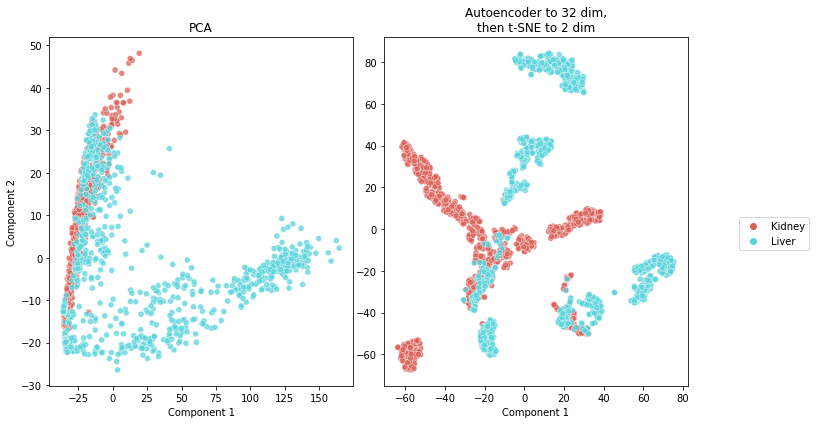

In [134]:
# Plot 2D representations
ncols = 2
fig, ax = plt.subplots(1, ncols, figsize=(12, 6))

x_dict = {
    'PCA': x_pca[:, :2],
    #'t-SNE': x_tsne2,
    'Autoencoder to 32 dim,\nthen t-SNE to 2 dim': x_encoded_tsne2,
}

n = len(x_dict)

for i, (title, x_plot) in enumerate(x_dict.items()):

    col = i
    ax_i = ax[col]

    sns.scatterplot(
        x=x_plot[:,0], y=x_plot[:,1],
        hue=y,
        palette=sns.color_palette("hls", 2),
        legend="full",
        alpha=0.75,
        ax=ax_i)
    if i == n - 1:
        handles, labels = ax_i.get_legend_handles_labels()
    ax_i.get_legend().remove()
    ax_i.set_title(title)
    ax_i.set_xlabel('Component 1')
    if col == 0:
        ax_i.set_ylabel('Component 2')

fig.legend(handles, labels, bbox_to_anchor=(0.9, 0.4), loc='lower center', ncol=1)
fig.tight_layout()
fig.subplots_adjust(right=0.8)

plt.savefig('figures/projection.jpg', format='jpg')
plt.show()